In [316]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# for number crunching
import numpy as np
import scipy.stats as stats
from sklearn.preprocessing import RobustScaler

# for dataset management
import pandas as pd

# for data visualization
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns

# Extre libraries
from datetime import datetime

/kaggle/input/online-retail-ii-uci/online_retail_II.csv


In [317]:
os.listdir('/kaggle/input/online-retail-ii-uci')

['online_retail_II.csv']

In [318]:
data = pd.read_csv('/kaggle/input/online-retail-ii-uci/online_retail_II.csv')

data.head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [319]:
data.columns
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


# Creating necessary columns

In [320]:
# Making sure Date is in datetime format
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Total ammount column
data['TotalAmount'] = data['Price'] * data['Quantity']

data.head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalAmount
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


# Dropping null columns

In [321]:
# Validating null values
data.isnull().sum()

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
TotalAmount         0
dtype: int64

In [322]:
# Validating negative values
(data[['Price', 'Quantity', 'TotalAmount']] < 0).sum()

Price              5
Quantity       22950
TotalAmount    19498
dtype: int64

In [323]:
# Deleting all rows with null values
data = data.dropna(subset = ['Customer ID'])

# Eliminating rows with negative quantities

# Note: don't eliminate this data, TO BE DETERMINED

data = data[data['Quantity'] >= 0]

data = data[data['Price'] >= 0]

In [324]:
# Validating null values again
data.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
TotalAmount    0
dtype: int64

In [325]:
# Validating negative values again
(data[['Price', 'Quantity', 'TotalAmount']] < 0).sum()

Price          0
Quantity       0
TotalAmount    0
dtype: int64

# Data Cleaning

<function matplotlib.pyplot.show(close=None, block=None)>

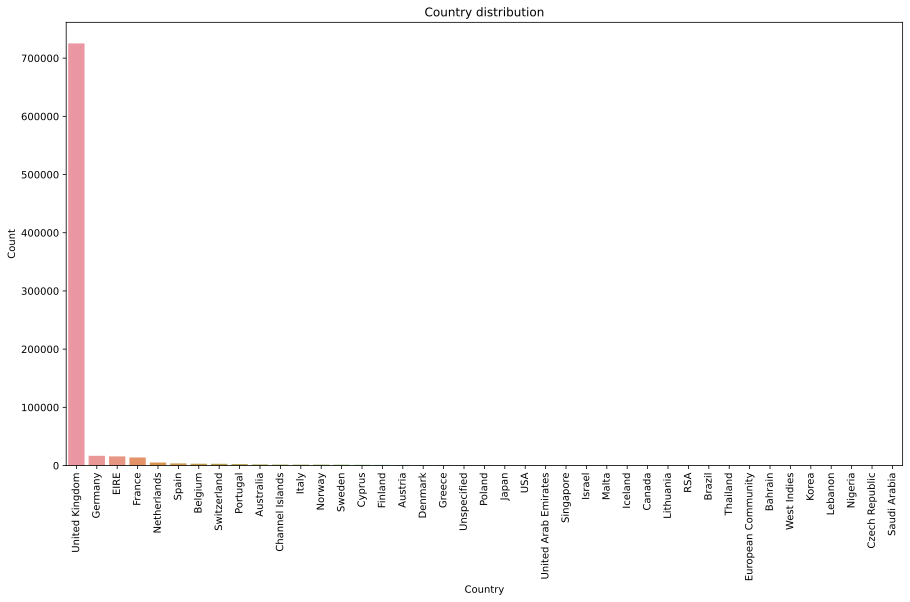

In [326]:
# Country distribution
plt.figure(figsize=(15, 8))
sns.countplot(data= data, x='Country', order=data['Country'].value_counts().index)
plt.title('Country distribution')
plt.xlabel('Country')
plt.ylabel('Count')
plt.xticks(rotation= 90)
plt.show

In [327]:
# We'll only work with transactions from the UK

# Keeping only transactions made in the UK
data = data[data['Country'] == 'United Kingdom']

In [328]:
print(data['Country'].describe())

count             725296
unique                 1
top       United Kingdom
freq              725296
Name: Country, dtype: object


# Price, Quantity and Total Amount distributions

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Quantity', ylabel='Percent'>

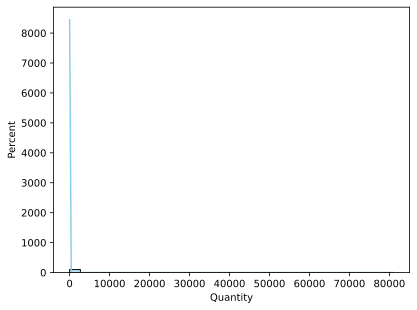

In [329]:
sns.histplot(data['Quantity'],bins=30, kde=True, color="skyblue", stat="percent")

In [330]:
# Distribution for Quantity
print(data['Quantity'].describe())

count    725296.000000
mean         12.021055
std         141.560253
min           1.000000
25%           2.000000
50%           4.000000
75%          12.000000
max       80995.000000
Name: Quantity, dtype: float64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Price', ylabel='Percent'>

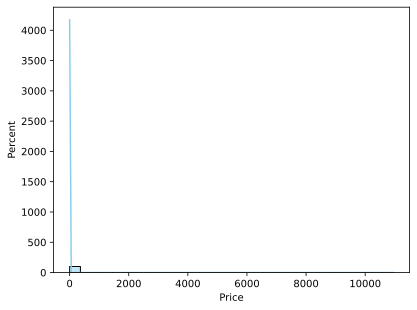

In [331]:
sns.histplot(data['Price'],bins=30, kde=True, color="skyblue", stat="percent")

In [332]:
# Distribution for Price
print(data['Price'].describe())

count    725296.000000
mean          3.056583
std          25.164725
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max       10953.500000
Name: Price, dtype: float64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='TotalAmount', ylabel='Percent'>

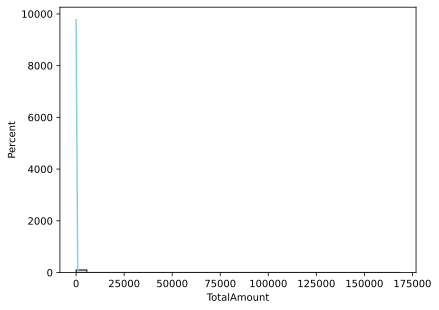

In [333]:
sns.histplot(data['TotalAmount'],bins=30, kde=True, color="skyblue", stat="percent")

In [334]:
# Distribution for TotalAmount
print(data['TotalAmount'].describe())

count    725296.000000
mean         20.299502
std         233.938767
min           0.000000
25%           4.200000
50%          10.200000
75%          17.700000
max      168469.600000
Name: TotalAmount, dtype: float64


# Data division between present and future

In [335]:
futureMax = data['InvoiceDate'].max()

print(futureMax)

2011-12-09 12:49:00


In [336]:
# Data delimitation (three months before)
presentvalue = pd.Timestamp('2011-09-01')

print(presentvalue)

2011-09-01 00:00:00


In [337]:
# Dividing data between present and future
futureData = data[(data['InvoiceDate'] > presentvalue) & (data['InvoiceDate'] <= presentvalue + pd.DateOffset(months=3))]

data = data[data['InvoiceDate'] <= presentvalue]

In [338]:
data.head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalAmount
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


In [339]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 571315 entries, 0 to 846153
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      571315 non-null  object        
 1   StockCode    571315 non-null  object        
 2   Description  571315 non-null  object        
 3   Quantity     571315 non-null  int64         
 4   InvoiceDate  571315 non-null  datetime64[ns]
 5   Price        571315 non-null  float64       
 6   Customer ID  571315 non-null  float64       
 7   Country      571315 non-null  object        
 8   TotalAmount  571315 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 43.6+ MB


In [340]:
futureData.head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalAmount
846166,565080,20677,PINK POLKADOT BOWL,8,2011-09-01 08:25:00,1.25,13509.0,United Kingdom,10.0
846167,565080,22128,PARTY CONES CANDY ASSORTED,24,2011-09-01 08:25:00,1.25,13509.0,United Kingdom,30.0
846169,565082,22423,REGENCY CAKESTAND 3 TIER,2,2011-09-01 09:15:00,12.75,13305.0,United Kingdom,25.5
846170,565082,15060B,FAIRY CAKE DESIGN UMBRELLA,8,2011-09-01 09:15:00,3.75,13305.0,United Kingdom,30.0
846171,565082,23245,SET OF 3 REGENCY CAKE TINS,4,2011-09-01 09:15:00,4.95,13305.0,United Kingdom,19.8


In [341]:
futureData.info()

<class 'pandas.core.frame.DataFrame'>
Index: 138180 entries, 846166 to 1041829
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      138180 non-null  object        
 1   StockCode    138180 non-null  object        
 2   Description  138180 non-null  object        
 3   Quantity     138180 non-null  int64         
 4   InvoiceDate  138180 non-null  datetime64[ns]
 5   Price        138180 non-null  float64       
 6   Customer ID  138180 non-null  float64       
 7   Country      138180 non-null  object        
 8   TotalAmount  138180 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 10.5+ MB


# Creating Customer Dataset

In [342]:
data.head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalAmount
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


In [343]:
# Calculating the "present day" for metrics like Recency
presentDay = presentvalue

# Calculate date metrics
firstPurchase = data.groupby('Customer ID')['InvoiceDate'].min()
lastPurchase = data.groupby('Customer ID')['InvoiceDate'].max()

# Calculate customer lifespan metrics
# We don't want 0 in active days. First day counts as 1.
activeDays = (lastPurchase - firstPurchase).dt.days + 1

# Recency calculation (Days since last purchase)
recency = (presentDay - lastPurchase).dt.days

activeYears = activeDays / 365.25
activeMonths = activeDays / 30.44

# A stabilization for active months so FrequencyPerMonth doesn't give
# new customer extreme values
activeMonthsSafe = np.maximum(activeMonths, 1)

# Frequency calculation
purchaseFrequency = data.groupby('Customer ID')['Invoice'].nunique()

# Monetary for calculations
monetary = data.groupby('Customer ID')['TotalAmount'].sum()

# Quantity calculation (calculating the total quantity per invoice)
invoiceQuantity = data.groupby(['Customer ID','Invoice'])['Quantity'].sum().reset_index()
avgQuantityPerInvoice = invoiceQuantity.groupby('Customer ID')['Quantity'].mean()

customerData = data.groupby('Customer ID').agg(

    # Monetary (Total Amount of purchases)
    Monetary = ('TotalAmount', 'sum'),
    
    # Average item Price
    #AvgPrice = ('Price', 'mean'), 
    
    # How many unique products bought
    ProductDiversity = ('StockCode', 'nunique')
)

# Recency calculation (Days since last purchase)
customerData['Recency'] = recency

# Frequency calculation
customerData['Frequency'] = purchaseFrequency

# Average order value calculation
customerData['AvgInvoiceValue'] = monetary / purchaseFrequency

# Average Quantity table merge
customerData['AvgQuantityPerInvoice'] = avgQuantityPerInvoice

# Active days
customerData['ActiveDays'] = activeDays

# Average item price
AvgPrice = data.groupby('Customer ID').apply(lambda x: x['TotalAmount'].sum() / x['Quantity'].sum()),

# Frequency per month
customerData['FrequencyPerMonth'] = purchaseFrequency / activeMonthsSafe

# Calculation of future CLV (spending in the next Quarter), which will be the target
futureCLV = futureData.groupby('Customer ID')['TotalAmount'].sum().rename('FutureCLV')
finalDataset = customerData.merge(futureCLV, how = 'left', left_index = True, right_index = True)
# Filling customers with no spending with a 0 value
finalDataset['FutureCLV'] = finalDataset['FutureCLV'].fillna(0)

# Eliminating customers with only 1 purchase as they only worsen the MAE
finalDataset = finalDataset[finalDataset['Frequency'] >= 2]

finalDataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3348 entries, 12346.0 to 18287.0
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Monetary               3348 non-null   float64
 1   ProductDiversity       3348 non-null   int64  
 2   Recency                3348 non-null   int64  
 3   Frequency              3348 non-null   int64  
 4   AvgInvoiceValue        3348 non-null   float64
 5   AvgQuantityPerInvoice  3348 non-null   float64
 6   ActiveDays             3348 non-null   int64  
 7   FrequencyPerMonth      3348 non-null   float64
 8   FutureCLV              3348 non-null   float64
dtypes: float64(5), int64(4)
memory usage: 261.6 KB


/tmp/ipykernel_47/1723918411.py:60: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  AvgPrice = data.groupby('Customer ID').apply(lambda x: x['TotalAmount'].sum() / x['Quantity'].sum()),


In [344]:
finalDataset.head(10)

,Monetary,ProductDiversity,Recency,Frequency,AvgInvoiceValue,AvgQuantityPerInvoice,ActiveDays,FrequencyPerMonth,FutureCLV
Customer ID,,,,,,,,,
12346.0,77556.46,27,225,12,6463.038333,6190.416667,401,0.910923,0.00
12745.0,723.85,20,386,2,361.925000,233.500000,88,0.691818,0.00
12747.0,7849.93,79,9,23,341.301304,101.956522,623,1.123788,988.11
12748.0,36448.21,1819,1,254,143.496890,86.862205,634,12.195205,19080.91
12749.0,5561.71,219,30,7,794.530000,281.285714,391,0.544962,572.59
12820.0,1917.64,91,226,8,239.705000,173.750000,408,0.596863,561.53
12821.0,220.80,13,114,2,110.400000,81.000000,398,0.152965,0.00
12823.0,5966.00,1,27,17,350.941176,50.588235,553,0.935769,535.50
12825.0,518.63,20,421,2,259.315000,69.500000,121,0.503140,0.00


In [345]:
# Saving a clean copy of the final dataset before cleaning it
rawCustomerDataset = finalDataset.copy()

# Client segmentation (Excluding clients with outlying purchase patters)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Monetary', ylabel='Percent'>

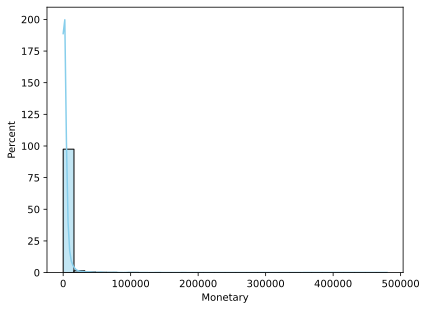

In [346]:
sns.histplot(finalDataset['Monetary'],bins=30, kde=True, color="skyblue", stat="percent")

In [347]:
print(finalDataset['Monetary'].describe())

count      3348.000000
mean       3339.453003
std       11780.065366
min          24.050000
25%         640.097500
50%        1299.300000
75%        2907.790000
max      479701.580000
Name: Monetary, dtype: float64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='AvgInvoiceValue', ylabel='Percent'>

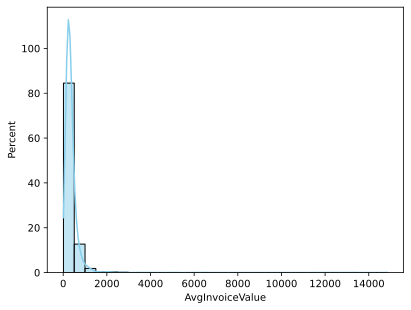

In [348]:
sns.histplot(finalDataset['AvgInvoiceValue'],bins=30, kde=True, color="skyblue", stat="percent")

In [349]:
print(finalDataset['AvgInvoiceValue'].describe())

count     3348.000000
mean       359.440502
std        461.433436
min         11.161333
25%        193.298125
50%        288.683214
75%        412.309000
max      14844.766667
Name: AvgInvoiceValue, dtype: float64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='AvgQuantityPerInvoice', ylabel='Percent'>

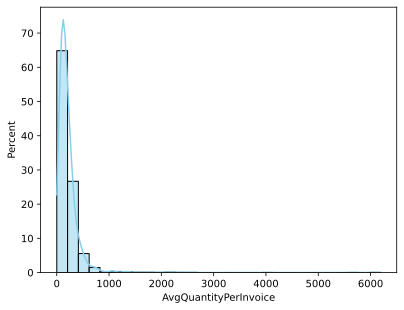

In [350]:
sns.histplot(finalDataset['AvgQuantityPerInvoice'],bins=30, kde=True, color="skyblue", stat="percent")

In [351]:
print(finalDataset['AvgQuantityPerInvoice'].describe())

count    3348.000000
mean      211.690400
std       273.739304
min         1.000000
25%        97.175000
50%       155.500000
75%       250.006757
max      6190.416667
Name: AvgQuantityPerInvoice, dtype: float64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='FrequencyPerMonth', ylabel='Percent'>

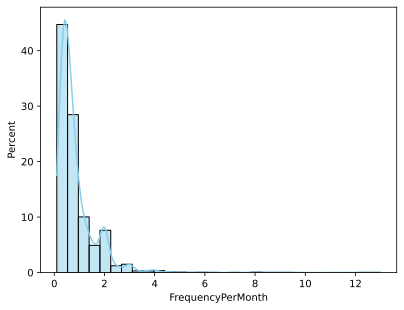

In [352]:
sns.histplot(finalDataset['FrequencyPerMonth'],bins=30, kde=True, color="skyblue", stat="percent")

In [353]:
print(finalDataset['FrequencyPerMonth'].describe())

count    3348.000000
mean        0.854818
std         0.835648
min         0.099477
25%         0.380302
50%         0.591068
75%         1.014667
max        12.997796
Name: FrequencyPerMonth, dtype: float64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Frequency', ylabel='Percent'>

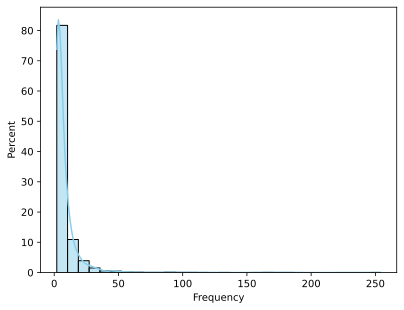

In [354]:
sns.histplot(finalDataset['Frequency'],bins=30, kde=True, color="skyblue", stat="percent")

In [355]:
print(finalDataset['Frequency'].describe())

count    3348.000000
mean        7.687276
std        12.096756
min         2.000000
25%         3.000000
50%         4.000000
75%         8.000000
max       254.000000
Name: Frequency, dtype: float64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='FutureCLV', ylabel='Percent'>

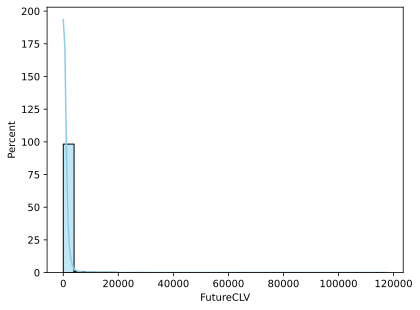

In [356]:
sns.histplot(finalDataset['FutureCLV'],bins=30, kde=True, color="skyblue", stat="percent")

In [357]:
print(finalDataset['FutureCLV'].describe())

count      3348.000000
mean        623.572706
std        3179.499670
min           0.000000
25%           0.000000
50%         109.335000
75%         590.877500
max      117634.530000
Name: FutureCLV, dtype: float64


In [358]:
#Dropping the outliers from data and saving them on other dataset!
# finalDatasetOutliersMonetary= finalDataset[finalDataset['Monetary'] > finalDataset['Monetary'].quantile(0.98)]

finalDataset = finalDataset[finalDataset['Monetary'] < finalDataset['Monetary'].quantile(0.98)]
finalDataset = finalDataset[finalDataset['AvgInvoiceValue'] < finalDataset['AvgInvoiceValue'].quantile(0.98)]
finalDataset = finalDataset[finalDataset['AvgQuantityPerInvoice'] < finalDataset['AvgQuantityPerInvoice'].quantile(0.98)]
finalDataset = finalDataset[finalDataset['Frequency'] < finalDataset['Frequency'].quantile(0.98)]
finalDataset = finalDataset[finalDataset['FrequencyPerMonth'] < finalDataset['FrequencyPerMonth'].quantile(0.99)]
finalDataset = finalDataset[finalDataset['FutureCLV'] < finalDataset['FutureCLV'].quantile(0.99)]
finalDataset = finalDataset[finalDataset['FrequencyPerMonth'] < finalDataset['FrequencyPerMonth'].quantile(0.99)]
finalDataset = finalDataset[finalDataset['ProductDiversity'] < finalDataset['ProductDiversity'].quantile(0.99)]

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Monetary', ylabel='Percent'>

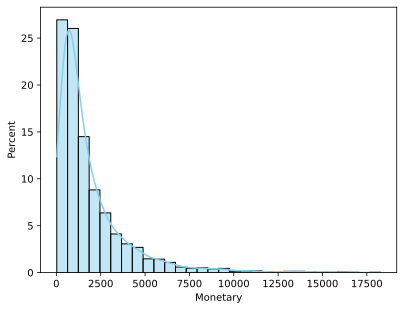

In [359]:
sns.histplot(finalDataset['Monetary'],bins=30, kde=True, color="skyblue", stat="percent")

In [360]:
print(finalDataset['Monetary'].describe())

count     2939.000000
mean      1872.909193
std       2069.594969
min         24.050000
25%        608.825000
50%       1153.850000
75%       2352.295000
max      18272.990000
Name: Monetary, dtype: float64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='AvgInvoiceValue', ylabel='Percent'>

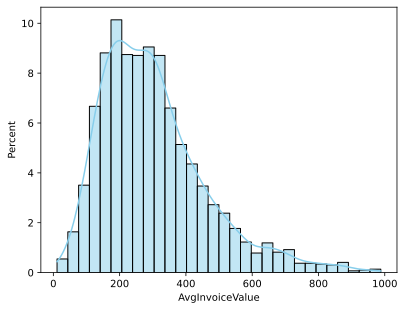

In [361]:
sns.histplot(finalDataset['AvgInvoiceValue'],bins=30, kde=True, color="skyblue", stat="percent")

In [362]:
print(finalDataset['AvgInvoiceValue'].describe())

count    2939.000000
mean      302.816805
std       159.611355
min        11.161333
25%       187.487714
50%       274.973333
75%       380.246667
max       988.000000
Name: AvgInvoiceValue, dtype: float64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='AvgQuantityPerInvoice', ylabel='Percent'>

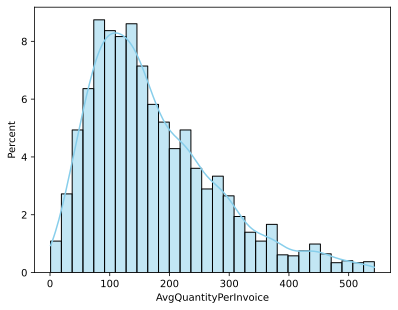

In [363]:
sns.histplot(finalDataset['AvgQuantityPerInvoice'],bins=30, kde=True, color="skyblue", stat="percent")

In [364]:
print(finalDataset['AvgQuantityPerInvoice'].describe())

count    2939.000000
mean      172.766873
std       105.632129
min         1.000000
25%        93.500000
50%       148.000000
75%       231.333333
max       543.000000
Name: AvgQuantityPerInvoice, dtype: float64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='FrequencyPerMonth', ylabel='Percent'>

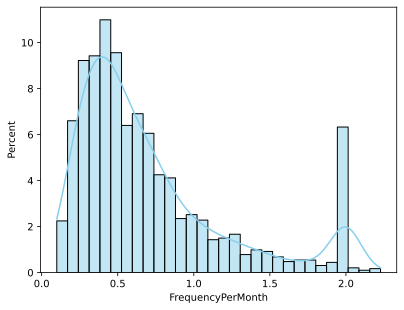

In [365]:
sns.histplot(finalDataset['FrequencyPerMonth'],bins=30, kde=True, color="skyblue", stat="percent")

In [366]:
print(finalDataset['FrequencyPerMonth'].describe())

count    2939.000000
mean        0.708233
std         0.495364
min         0.099477
25%         0.366432
50%         0.548468
75%         0.868939
max         2.227317
Name: FrequencyPerMonth, dtype: float64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Frequency', ylabel='Percent'>

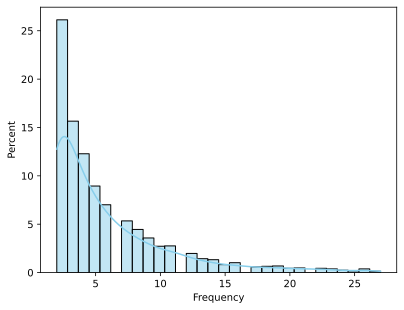

In [367]:
sns.histplot(finalDataset['Frequency'],bins=30, kde=True, color="skyblue", stat="percent")

In [368]:
print(finalDataset['Frequency'].describe())

count    2939.000000
mean        5.822729
std         4.709919
min         2.000000
25%         2.000000
50%         4.000000
75%         7.000000
max        27.000000
Name: Frequency, dtype: float64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='FutureCLV', ylabel='Percent'>

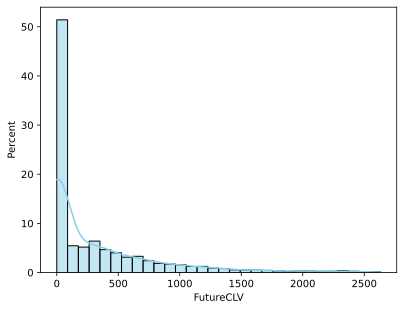

In [369]:
sns.histplot(finalDataset['FutureCLV'],bins=30, kde=True, color="skyblue", stat="percent")

In [370]:
print(finalDataset['FutureCLV'].describe())

count    2939.000000
mean      322.214648
std       492.106680
min         0.000000
25%         0.000000
50%        30.790000
75%       479.930000
max      2632.380000
Name: FutureCLV, dtype: float64


# Normalizacion de la data

In [371]:
modelData = finalDataset.copy()

In [372]:
# Hacer log transform a la data numerica con heavy-tail
logCols = ['Monetary', 'AvgInvoiceValue', 'AvgQuantityPerInvoice', 'Frequency']

for col in logCols:
    modelData[col] = np.log1p(modelData[col])

In [373]:
# Robust scaling for features

featureCols = ['Monetary', 'AvgInvoiceValue', 'AvgQuantityPerInvoice', 'Frequency', 'Recency', 'ActiveDays', 'FrequencyPerMonth', 'ProductDiversity']

scaler = RobustScaler()
modelData[featureCols] = scaler.fit_transform(modelData[featureCols])

In [374]:
modelData[featureCols].describe()

,Monetary,AvgInvoiceValue,AvgQuantityPerInvoice,Frequency,Recency,ActiveDays,FrequencyPerMonth,ProductDiversity
count,2939.000000,2939.000000,2939.000000,2939.000000,2939.000000,2939.000000,2939.000000,2939.000000
mean,0.020665,-0.061712,-0.055825,0.132625,0.205851,-0.006657,0.317935,0.287078
std,0.713723,0.783963,0.773767,0.582708,0.588350,0.573557,0.985786,0.927051
min,-2.836828,-4.432115,-4.792049,-0.520810,-0.474576,-0.987382,-0.893502,-0.734177
25%,-0.472863,-0.541261,-0.506181,-0.520810,-0.296610,-0.507886,-0.362257,-0.367089
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.527137,0.458739,0.493819,0.479190,0.703390,0.492114,0.637743,0.632911
max,2.044956,1.811989,1.439575,1.756439,2.220339,1.018927,3.340944,4.544304


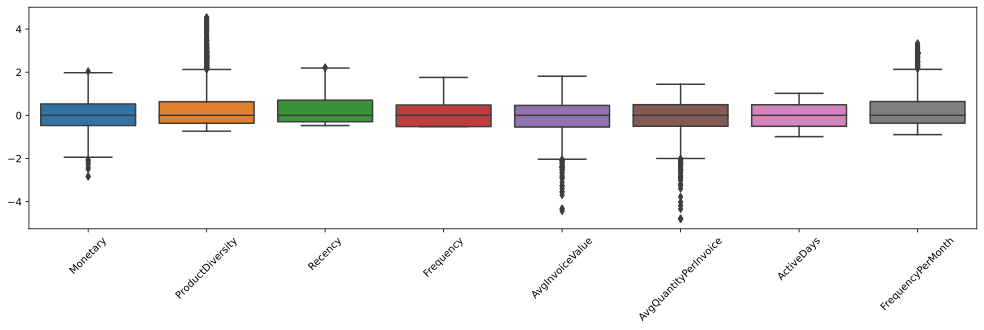

In [375]:
# check the new distribution
Showdata=modelData.drop(columns=['FutureCLV'])
fig,ax = plt.subplots(1,figsize=(17,4))
ax = sns.boxplot(Showdata)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.show()

# Definition of train/test/val datasets

In [376]:
# Separating features from target
X = modelData.drop(columns=['FutureCLV'])
y = modelData['FutureCLV']

# Split en train, test y val (70%, 15%, 15%)

# Train and temp split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42)

# Val and test splot
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)

# Pandas dataframe to tensor conversion
X_train_t = torch.tensor(X_train.values).float()
X_val_t   = torch.tensor(X_val.values).float()
X_test_t  = torch.tensor(X_test.values).float()

y_train_t = torch.tensor(y_train.values).float().unsqueeze(1)
y_val_t   = torch.tensor(y_val.values).float().unsqueeze(1)
y_test_t  = torch.tensor(y_test.values).float().unsqueeze(1)

In [377]:
# Dataloaders

batchSize = 32

train_ds = TensorDataset(X_train_t, y_train_t)
val_ds = TensorDataset(X_val_t, y_val_t)
test_ds = TensorDataset(X_test_t, y_test_t)

trainLoader = DataLoader(train_ds, batch_size=batchSize, shuffle=True)
valLoader = DataLoader(val_ds, batch_size=batchSize, shuffle=True)
testLoader = DataLoader(test_ds, batch_size=batchSize, shuffle=True)

In [378]:
print(X_train_t.shape)
print(X_val_t.shape)
print(X_test_t.shape)

torch.Size([2057, 8])
torch.Size([441, 8])
torch.Size([441, 8])


# Creating and trainning the FFNN

In [379]:
# Creating a class for the model without batchnorm

class FFNN(nn.Module):
  def __init__(self):
    super().__init__()

    # input layer
    self.input = nn.Linear(8,32)

    # hidden layer 1
    self.fc1    = nn.Linear(32,16)

    # hidden layer 2
    self.fc2    = nn.Linear(16,8)

    # output layer
    self.output = nn.Linear(8,1)

    # Dropout
    self.dropout = nn.Dropout(p=0.15)

  # forward pass
  def forward(self,x):

    # input
    x = self.input(x)    # weighted combination
    x = F.relu(x)      # activation function 
      
    # hidden layer 1
    x = self.fc1(x)    # weighted combination
    x = F.relu(x)      # activation function
    x = self.dropout(x)  # dropout
    
    # hidden layer 2
    x = self.fc2(x)    # weighted combination
    x = F.relu(x)      # activation function 

    # output layer
    return self.output(x)

In [380]:
# grab an instance of the model class
model = FFNN()

# loss function
# we should use Huberloss() because its better for outliers
lossfun = nn.HuberLoss() # Could use nn.MSELoss() but HuberLoss() is better in this case

# optimizer with L2 Regularization (weight_decay=0.0a01)
optimizer = torch.optim.AdamW(model.parameters(),lr= 0.001,weight_decay=0.0001)

# Scheduler for learning rate decay
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,     # reduce LR by half
    patience=10,     # wait 15 epochs with no improvement
    min_lr = 0.000001,
    verbose = True # helps debugging
)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [381]:
# # train the model

# # global parameter
# numepochs = 100

# def trainTheModel():

#     # initialize losses as empties
#     trainLosses = []
#     valLosses = []  
#     maes = []
    
#     # loop over epochs
#     for epochi in range(numepochs):
    
#         # Toggle train mode
#         model.train()
#         batchLoss = []
          
#         # initialize batchAcc and batchLoss
#         batchAcc  = []
#         batchLoss = []
        
#         for X,y in train_loader:
        
#           # forward pass and loss
#           yHat = model(X)
#           loss = lossfun(yHat,y)
        
#           # backprop
#           optimizer.zero_grad()
#           loss.backward()
#           optimizer.step()
        
#           # Append batch Loss
#           batchLoss.append( loss.item() )
          
#         # Average trainning loss for this epoch
#         trainLoss = np.mean(batchLoss)
#         trainLosses.append(trainLoss)

#         # Turning on validation mode
#         model.eval()
#         with torch.no_grad():
#             Xtest, ytest = next(iter(test_loader))

#             # Prediction in log-space
#             yhatNormalized = model(Xtest)
            
#             # Val losses in log-space
#             valLoss = lossfun(yhatNormalized, ytest).item()
#             valLosses.append(valLoss)

#             # Denormalization (Undoing z-score)
#             yhatLog = yhatNormalized * label_std + label_mean
#             ytestLog = ytest * label_std + label_mean

#             # MAE (Mean Absolute Error) in real CLV space
            
#             # De-LogTransform yhat and y
#             yhatClv = torch.expm1(yhatLog)
#             ytrueClv = torch.expm1(ytestLog)

#             # MAE
#             mae = torch.mean(torch.abs(yhatClv - ytrueClv)).item()
#             maes.append(mae)
            
#         # Scheduler
#         scheduler.step(valLoss)

#         # Progress print
#         print(f"Epoch {epochi} | Train Loss: {trainLoss:.4f} | Val Loss: {valLoss:.4f} | MAE: {mae:.4f}")
#         print("LR:", scheduler.optimizer.param_groups[0]['lr'])
    
#     # function output
#     return trainLosses, valLosses

In [382]:
# # Train the model
# trainLosses, valLosses = trainTheModel()

In [383]:
# plt.figure(figsize=(10,6))

# plt.plot(trainLosses, label='Training Loss', linewidth=2)
# plt.plot(valLosses, label='Validation Loss', linewidth=2)

# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training vs Validation Loss')
# plt.legend()
# plt.grid(True)
# plt.show()